In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision

is_gpu_present = torch.cuda.is_available()
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

if is_gpu_present:
    print('GPU detected!')
else:
    print('CPU detected!')

GPU detected!


In [2]:
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler

#number of sub-process to use while data-loading
num_workers = 0

#how many samples per batch?
batch_size = 20

#percentage of data to be used as validation/test
valid_size = 0.2

# convert data to normalized torch.floatTensor
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

#randomly split data to valid and train set
valid_len = int(valid_size * len(train_data))
valid_data,train_data = torch.utils.data.random_split(train_data, [valid_len, len(train_data)  - valid_len])

print('Train: ', len(train_data))
print('Test: ', len(test_data))
print('Valid: ', len(valid_data))

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
    shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)


# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170498071/170498071 [00:05<00:00, 29872776.04it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Train:  40000
Test:  10000
Valid:  10000


## Visualization

In [3]:
from torch import Tensor
import matplotlib.pyplot as plt
%matplotlib inline


#helper fucntion to de-normalize the image and print

def imshow(img):
    img = img/2 + 0.5
    plt.imshow(np.transpose(img, (1,2,0)))


(20, 3, 32, 32)


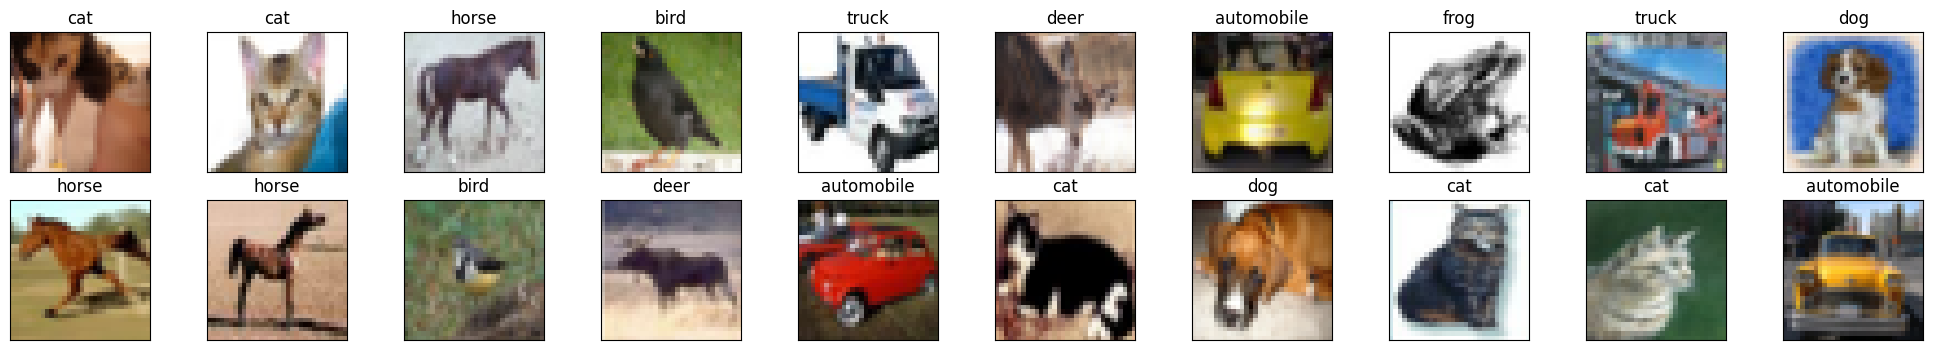

In [4]:
#obtain one batch of trainloader

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()
print(images.shape)


##plot images in batch along labels

fig = plt.figure(figsize = (25, 4))

#display 20 images

for idx in range(20):
    ax = fig.add_subplot(2, 20//2, idx+1,xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

# view image in seperate color channels

In [5]:
rgb_img = np.squeeze(images[3])
print(rgb_img.shape)
channels = ['red channel', 'green channel', 'blue channel']

for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 4, idx + 2)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

(3, 32, 32)


# Now Define network architecture

In [6]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)

        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)

        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)

        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)

        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function

        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x


model = Net()
print(model)

if is_gpu_present:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


# Specify loss and Optimizer

In [7]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the Network

In [8]:
num_epochs = 15
valid_loss_min = np.Inf

train_loss_list = []
valid_loss_list = []

for epoch in range(num_epochs):

    train_loss, valid_loss = 0.0, 0.0

    #train the model now

    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if is_gpu_present:
            data, target = data.cuda(), target.cuda()

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        output = model(data)

        #calculate loss
        loss = criterion(output, target)


        loss.backward()

        optimizer.step()

        train_loss += loss.item()*data.size(0)


    #Validate the model


    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if is_gpu_present:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)


    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 0 	Training Loss: 42.337597 	Validation Loss: 36.439072
Validation loss decreased (inf --> 36.439072).  Saving model ...
Epoch: 1 	Training Loss: 33.589427 	Validation Loss: 30.476809
Validation loss decreased (36.439072 --> 30.476809).  Saving model ...
Epoch: 2 	Training Loss: 29.669649 	Validation Loss: 28.216039
Validation loss decreased (30.476809 --> 28.216039).  Saving model ...
Epoch: 3 	Training Loss: 27.377279 	Validation Loss: 26.414630
Validation loss decreased (28.216039 --> 26.414630).  Saving model ...
Epoch: 4 	Training Loss: 25.452703 	Validation Loss: 24.565847
Validation loss decreased (26.414630 --> 24.565847).  Saving model ...
Epoch: 5 	Training Loss: 23.825138 	Validation Loss: 23.380911
Validation loss decreased (24.565847 --> 23.380911).  Saving model ...
Epoch: 6 	Training Loss: 22.418251 	Validation Loss: 22.582060
Validation loss decreased (23.380911 --> 22.582060).  Saving model ...
Epoch: 7 	Training Loss: 21.093974 	Validation Loss: 22.141084
Valid

# Load model with lowest valid loss

In [9]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

# Test the model

In [10]:
test_loss = 0.0
test_correct = [0.0]*10
test_total = [0.0]*10


model.eval()
for data,target in test_loader:
    # move tensors to GPU if CUDA is available
    if is_gpu_present:
        data, target = data.cuda(), target.cuda()

    output = model(data)

    loss = criterion(output, target)

    test_loss = loss.item()*data.size(0)

    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)

    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not is_gpu_present else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        test_correct[label] += correct[i].item()
        test_total[label] += 1

#average test loss

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if test_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * test_correct[i] / test_total[i],
            np.sum(test_correct[i]), np.sum(test_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(test_correct) / np.sum(test_total),
    np.sum(test_correct), np.sum(test_total)))


Test Loss: 0.002114

Test Accuracy of airplane: 76% (761/1000)
Test Accuracy of automobile: 83% (833/1000)
Test Accuracy of  bird: 61% (616/1000)
Test Accuracy of   cat: 44% (445/1000)
Test Accuracy of  deer: 66% (669/1000)
Test Accuracy of   dog: 68% (682/1000)
Test Accuracy of  frog: 80% (809/1000)
Test Accuracy of horse: 75% (757/1000)
Test Accuracy of  ship: 89% (892/1000)
Test Accuracy of truck: 77% (777/1000)

Test Accuracy (Overall): 72% (7241/10000)


In [ ]:
print(len(train_loss_list))
print(len(valid_loss_list))

15
15


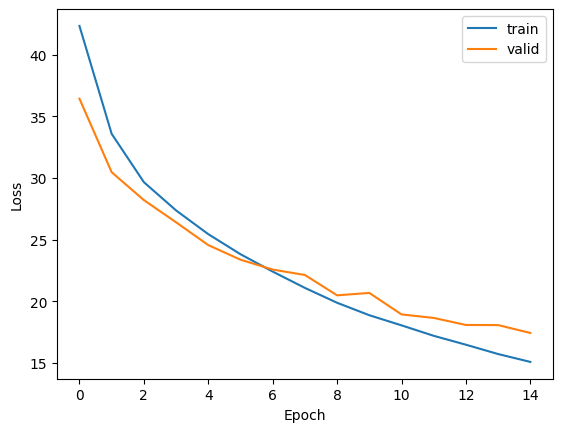

In [11]:
plt.plot(train_loss_list,label='train')
plt.plot(valid_loss_list,label='valid')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Visualize test sample results

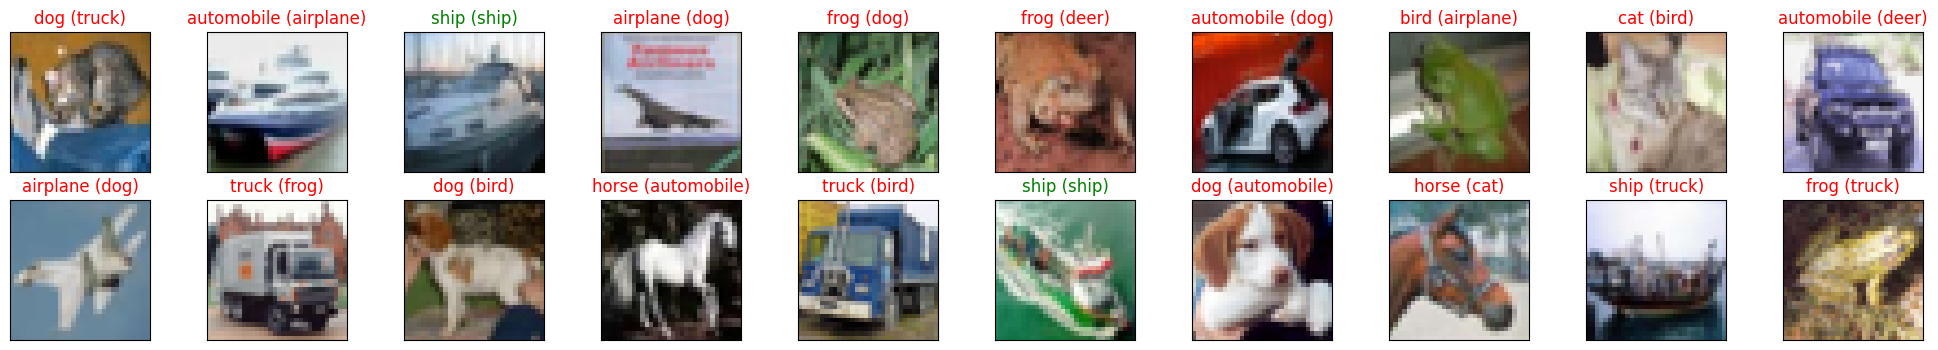

In [ ]:
dataiter = iter(test_loader)
images,label = next(dataiter)
images.numpy()


# move model inputs to cuda, if GPU available
if is_gpu_present:
    images = images.cuda()


#get output
output = model(images)


_, preds_tensor= torch.max(output, 1)

preds = np.squeeze(preds_tensor.numpy()) if not is_gpu_present else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    imshow(Tensor.cpu(images[idx]))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))